In [1]:
import os
import sys
import re
import math
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split

import networkx as nx
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from functions.data_loader import data_loader
from classes.smiles_to_graph import MolecularGraphFromSMILES
from classes.MPNN import MPNN
from functions.compute_loss import compute_loss
from functions.evaluations import *
from functions.evaluations import evaluate_model
from functions.train import train_MPNN_model

# onderdelen die we importeren voor de visualisatie
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

# Onderdelen voor de k fold validation
from collections import defaultdict
from sklearn.model_selection import KFold

# Load the data and couple the SMILES to the yields and remove nan's

In [2]:
yields_path = "data/compounds_yield.csv"
smiles_path = "data/compounds_smiles.csv"

df_merged = data_loader(yields_path, smiles_path)


#print("Merged DataFrame:")
#print(df_merged)


Convert the SMILES to Graphs

## Zet de SMILES om naar graphs

In [3]:

graphs = []
for _, row in tqdm(df_merged.iterrows(), total=len(df_merged), desc="Converting SMILES to graphs"):
    try:
        mol_graph = MolecularGraphFromSMILES(row['smiles_raw'])

        graph = mol_graph.to_pyg_data()
        graphs.append(graph)

    except Exception as e:
        print(f"Fout bij SMILES: {row['smiles_raw']}")
        mol = Chem.MolFromSmiles(row['smiles_raw'])
        if mol:
            print(f"  - aantal atomen in RDKit mol: {mol.GetNumAtoms()}")
        else:
            print("  - RDKit kon mol niet parsen!")
        print(f"  - foutmelding: {e}")


# Eerste splitsing: 85% train+val, 15% test
train_val_graphs, test_graphs = train_test_split(
    graphs, test_size=0.15, random_state=42
)

# Tweede splitsing: 70/15 = 70/85, 0.8235 voor train
train_graphs, val_graphs = train_test_split(
    train_val_graphs, test_size=0.1765, random_state=42
)


Converting SMILES to graphs: 100%|██████████| 83/83 [00:00<00:00, 91.55it/s] 


## Zet de graphs in een dataloader zodat het de GNN in kan

[Epoch 1] Train loss: 0.8227 | Site: 1.5923, Yield: 0.0531
[Epoch 2] Train loss: 0.6710 | Site: 1.3244, Yield: 0.0176
[Epoch 3] Train loss: 0.5902 | Site: 1.1614, Yield: 0.0191
[Epoch 4] Train loss: 0.5117 | Site: 0.9991, Yield: 0.0243
[Epoch 5] Train loss: 0.5402 | Site: 1.0571, Yield: 0.0233
[Epoch 6] Train loss: 0.4359 | Site: 0.8492, Yield: 0.0225
[Epoch 7] Train loss: 0.3677 | Site: 0.6997, Yield: 0.0358
[Epoch 8] Train loss: 0.2887 | Site: 0.5458, Yield: 0.0317
[Epoch 9] Train loss: 0.2235 | Site: 0.4143, Yield: 0.0327
[Epoch 10] Train loss: 0.2183 | Site: 0.4042, Yield: 0.0324
[Epoch 11] Train loss: 0.2107 | Site: 0.4017, Yield: 0.0197
[Epoch 12] Train loss: 0.1502 | Site: 0.2655, Yield: 0.0350
[Epoch 13] Train loss: 0.1414 | Site: 0.2522, Yield: 0.0306
[Epoch 14] Train loss: 0.1829 | Site: 0.3366, Yield: 0.0293
[Epoch 15] Train loss: 0.1819 | Site: 0.3423, Yield: 0.0216
[Epoch 16] Train loss: 0.1721 | Site: 0.3119, Yield: 0.0323
[Epoch 17] Train loss: 0.2061 | Site: 0.3958, Yie

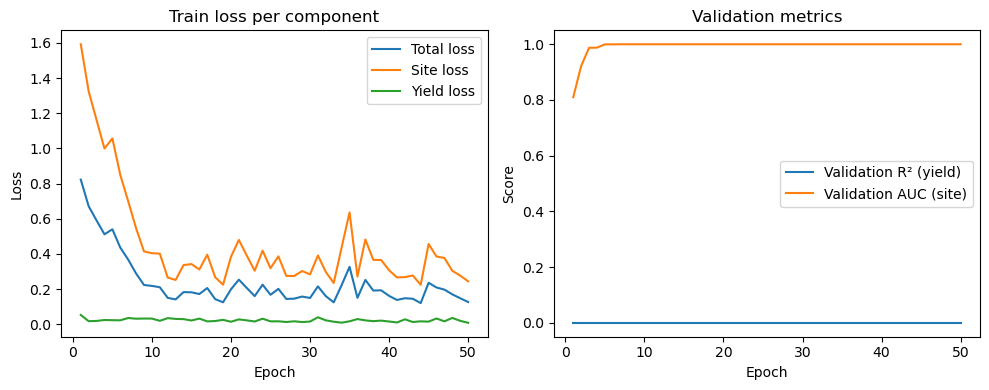

 Testresultaten:

 Borylation site prediction:
   - Accuracy      : 1.000
   - Precision     : 1.000
   - ROC AUC       : 1.000
   - Top-1 Accuracy: 1.000
   - Top-3 Accuracy: 1.000

 Yield prediction:
   - MSE           : 0.004
   - MAE           : 0.063
   - R²            : 0.000
Gemiddelde voorspelde yield: 0.267554
Gemiddelde echte yield: 0.3303587


In [ ]:
# Instellingen
batch_size = 16
num_epochs = 50
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Architecture MPNN
node_in_feats=train_graphs[0].x.shape[1]                # Aantal input features per node
edge_in_feats=train_graphs[0].edge_attr.shape[1]        # Aantal input features per edge
hidden_feats=256                                         # Aantal verborgen features
num_step_message_passing=3                              # Aantal stappen voor message passing
#num_step_set2set=3                                      # Aantal stappen voor Set2Set
#num_layer_set2set=1                                     # Aantal lagen voor Set2Set
readout_feats=512                                      # Aantal features voor readout
activation='leaky_relu'                                 # Activatiefunctie
dropout=0.2                                            # Dropout percentage

# DataLoaders
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)


# Initialiseer model
model = MPNN(
    node_in_feats=node_in_feats,
    edge_in_feats=edge_in_feats,
    hidden_feats=hidden_feats,
    num_step_message_passing=num_step_message_passing,
    # komt er hier iets anders voor in de plaats->vragen aan Max
    # plus mentionen dat in een van de classes nog iets in nederlands erbij stond en vragen of dat weg kan
    #num_step_set2set=num_step_set2set,
    #num_layer_set2set=num_layer_set2set,
    readout_feats=readout_feats,
    activation=activation,
    dropout=dropout
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop met validatie

train_total_loss_list = []
train_site_loss_list = []
train_yield_loss_list = []

val_r2_list = []
val_auc_list = []


for epoch in range(num_epochs):
    train_losses = train_MPNN_model(model, train_loader, optimizer, device)
    val_metrics, val_y_true, val_y_pred = evaluate_model(model, val_loader, device)

    print(f"[Epoch {epoch+1}] Train loss: {train_losses['total']:.4f} | "
        f"Site: {train_losses['site']:.4f}, "
        f"Yield: {train_losses['yield']:.4f}")
    train_total_loss_list.append(train_losses['total'])
    train_site_loss_list.append(train_losses['site'])
    train_yield_loss_list.append(train_losses['yield'])

    val_r2_list.append(float(val_metrics['yield_R2']))
    val_auc_list.append(val_metrics['site_AUC'])

# Evaluatie op testset na training
print("Evaluatie op testset na training:")
test_metrics, y_true, y_pred = evaluate_model(model, test_loader, device)

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_total_loss_list, label="Total loss")
plt.plot(epochs, train_site_loss_list, label="Site loss")
plt.plot(epochs, train_yield_loss_list, label="Yield loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train loss per component")
plt.legend()

# Validation metrics
plt.subplot(1, 2, 2)
plt.plot(epochs, val_r2_list, label="Validation R² (yield)")
plt.plot(epochs, val_auc_list, label="Validation AUC (site)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation metrics")
plt.legend()

plt.tight_layout()
plt.show()


# Bereken Top-k accuracies (k=1 en k=3)
all_site_logits = []
all_site_masks = []
all_batches = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        p_borylation, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)

        all_site_logits.append(torch.sigmoid(p_borylation))  # sigmoid omdat topk op probs werkt
        all_site_masks.append(batch.borylation_mask)
        all_batches.append(batch.batch)

p_borylation = torch.cat(all_site_logits)
borylation_mask = torch.cat(all_site_masks)
batch_tensor = torch.cat(all_batches)

acc_top1 = topk_accuracy(p_borylation, borylation_mask, batch_tensor, k=1)
acc_top3 = topk_accuracy(p_borylation, borylation_mask, batch_tensor, k=3)

# Print resultaten
print(" Testresultaten:")
print(f"\n Borylation site prediction:")
print(f"   - Accuracy      : {test_metrics['site_Accuracy']:.3f}")
print(f"   - Precision     : {test_metrics['site_Precision']:.3f}")
print(f"   - ROC AUC       : {test_metrics['site_AUC']:.3f}")
print(f"   - Top-1 Accuracy: {acc_top1:.3f}")
print(f"   - Top-3 Accuracy: {acc_top3:.3f}")

print(f"\n Yield prediction:")
print(f"   - MSE           : {test_metrics['yield_MSE']:.3f}")
print(f"   - MAE           : {test_metrics['yield_MAE']:.3f}")
print(f"   - R²            : {test_metrics['yield_R2']:.3f}")

print("Gemiddelde voorspelde yield:", y_pred.mean())
print("Gemiddelde echte yield:", y_true.mean())






The prediction and visualisation of the borylation reactivity for new molecules using our trained MPNN

Predicted yield: 0.2714
Borylation site probabilities per atom:
  Atom 0: 0.9969
  Atom 1: 0.0016
  Atom 2: 0.0082
  Atom 3: 0.0011
  Atom 4: 0.0020
  Atom 5: 0.0018
  Atom 6: 0.0018
  Atom 7: 0.0018
  Atom 8: 0.0018
  Atom 9: 0.0036
  Atom 10: 0.0015


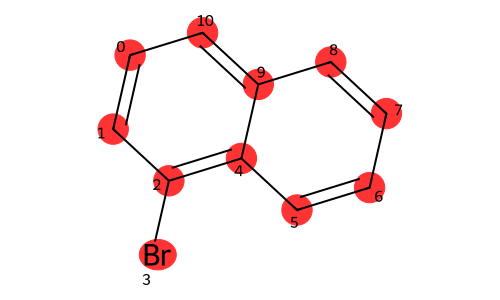

In [8]:
# Input SMILES string
#smiles_str = 'CC1=CC(=O)OC2=C1C=CC(=C2)Br'
#smiles_str = 'c2ccc1NCCc1c2'
#smiles_str = 'c1c(OC)cccc1'
smiles_str = 'c2cc(Br)c1ccccc1c2'

# Convert to graph
mol_graph = MolecularGraphFromSMILES(smiles_str)
graph = mol_graph.to_pyg_data()
graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)  # single molecule batch
graph = graph.to(device)

# Inference
model.eval()
with torch.no_grad():
    site_logits, predicted_yield = model(
        graph.x, graph.edge_index, graph.edge_attr, graph.batch
    )
    probs = torch.sigmoid(site_logits).cpu().numpy()
    yield_pred = predicted_yield.item()

print("Predicted yield:", round(yield_pred, 4))
print("Borylation site probabilities per atom:")
for i, prob in enumerate(probs):
    print(f"  Atom {i}: {prob:.4f}")

# Visualize the molecule with highlighted atoms based on predicted probabilities
mol = Chem.MolFromSmiles(smiles_str)
drawer = rdMolDraw2D.MolDraw2DSVG(500, 300)
drawer.drawOptions().addAtomIndices = True  # Show atom indices

# Color atoms by probability
atom_colors = {
    i: (1.0, 0.2, 0.2, float(prob))
    for i, prob in enumerate(probs)
}
rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=atom_colors.keys(), highlightAtomColors=atom_colors)
drawer.FinishDrawing()

# Display
svg = drawer.GetDrawingText()
display(SVG(svg))

In [10]:
# Stel K-fold in
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Instellingen
batch_size = 16
num_epochs = 30
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Architecture MPNN
node_in_feats=train_graphs[0].x.shape[1]                # Aantal input features per node
edge_in_feats=train_graphs[0].edge_attr.shape[1]        # Aantal input features per edge
hidden_feats=256                                         # Aantal verborgen features
#num_step_message_passing=3                              # Aantal stappen voor message passing
#num_step_set2set=3                                      # Aantal stappen voor Set2Set
num_layer_set2set=1                                     # Aantal lagen voor Set2Set
readout_feats=512                                      # Aantal features voor readout
activation='leaky_relu'                                 # Activatiefunctie
dropout=0.2                                            # Dropout percentage


results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs)):
    print(f"\n--- Fold {fold+1} ---")

    train_graphs = [graphs[i] for i in train_idx]
    val_graphs = [graphs[i] for i in val_idx]

    # DataLoaders
    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)

    # Init model opnieuw per fold
    model = MPNN(
        node_in_feats=node_in_feats,
        edge_in_feats=edge_in_feats,
        hidden_feats=hidden_feats,
        num_step_message_passing=num_step_message_passing,
        #num_step_set2set=num_step_set2set,
        #num_layer_set2set=num_layer_set2set,
        readout_feats=readout_feats,
        activation=activation,
        dropout=dropout
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train per fold
    for epoch in range(num_epochs):
        train_losses = train_MPNN_model(model, train_loader, optimizer, device)

    # Eval per fold
    metrics, _, _ = evaluate_model(model, val_loader, device)
    results.append(metrics)

# Gemiddelde resultaten berekenen
avg_metrics = defaultdict(list)
for metrics in results:
    for key, val in metrics.items():
        avg_metrics[key].append(val)

print("\nGemiddelde resultaten over folds:")
for key, values in avg_metrics.items():
    mean = sum(values) / len(values)
    std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
    print(f"{key:20s}: {mean:.4f} ± {std:.4f}")


--- Fold 1 ---

--- Fold 2 ---


c:\Users\Carlijn\miniconda3\envs\ml4chem_gnn\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



--- Fold 3 ---


c:\Users\Carlijn\miniconda3\envs\ml4chem_gnn\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



--- Fold 4 ---


c:\Users\Carlijn\miniconda3\envs\ml4chem_gnn\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



--- Fold 5 ---


c:\Users\Carlijn\miniconda3\envs\ml4chem_gnn\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Gemiddelde resultaten over folds:
yield_MSE           : 0.0052 ± 0.0015
yield_MAE           : 0.0716 ± 0.0098
yield_R2            : 0.0000 ± 0.0000
site_Accuracy       : 0.9989 ± 0.0022
site_Precision      : 1.0000 ± 0.0000
site_AUC            : 1.0000 ± 0.0000


Predicted yield: 0.2586
Borylation site probabilities per atom:
  Atom 0: 0.9951
  Atom 1: 0.0030
  Atom 2: 0.0142
  Atom 3: 0.0016
  Atom 4: 0.0052
  Atom 5: 0.0063
  Atom 6: 0.0061
  Atom 7: 0.0061
  Atom 8: 0.0056
  Atom 9: 0.0086
  Atom 10: 0.0038


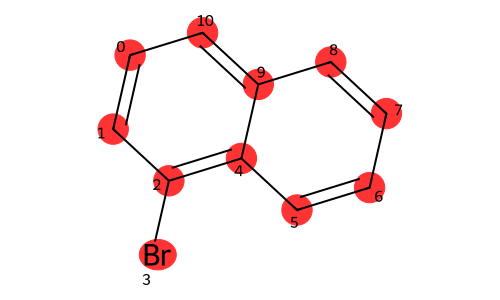

In [12]:
# Input SMILES string
#smiles_str = 'CC1=CC(=O)OC2=C1C=CC(=C2)Br'
#smiles_str = 'c2ccc1NCCc1c2'
#smiles_str = 'c1c(OC)cccc1'
smiles_str = 'c2cc(Br)c1ccccc1c2'

# Convert to graph
mol_graph = MolecularGraphFromSMILES(smiles_str)
graph = mol_graph.to_pyg_data()
graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long)  # single molecule batch
graph = graph.to(device)

# Inference
model.eval()
with torch.no_grad():
    site_logits, predicted_yield = model(
        graph.x, graph.edge_index, graph.edge_attr, graph.batch
    )
    probs = torch.sigmoid(site_logits).cpu().numpy()
    yield_pred = predicted_yield.item()

print("Predicted yield:", round(yield_pred, 4))
print("Borylation site probabilities per atom:")
for i, prob in enumerate(probs):
    print(f"  Atom {i}: {prob:.4f}")

# Visualize the molecule with highlighted atoms based on predicted probabilities
mol = Chem.MolFromSmiles(smiles_str)
drawer = rdMolDraw2D.MolDraw2DSVG(500, 300)
drawer.drawOptions().addAtomIndices = True  # Show atom indices

# Color atoms by probability
atom_colors = {
    i: (1.0, 0.2, 0.2, float(prob))  # red color with alpha = probability
    for i, prob in enumerate(probs)
}
rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=atom_colors.keys(), highlightAtomColors=atom_colors)
drawer.FinishDrawing()

# Display the SVG
svg = drawer.GetDrawingText()
display(SVG(svg))

In [19]:
# Check how often atom 0 is the max predicted site
from tqdm import tqdm
from torch_geometric.loader import DataLoader

#from comounds import your_dataset  # ← adjust this import

dataloader = DataLoader(val_graphs, batch_size=32, shuffle=False)

count_atom0 = 0
total_mols = 0

model.eval()
with torch.no_grad():
    for batch in tqdm(dataloader):
        batch = batch.to(device)
        site_logits, _ = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        probs = torch.sigmoid(site_logits)

        for i in range(batch.batch.max().item() + 1):
            mask = batch.batch == i
            if mask.sum() == 0:
                continue
            atom_idx = probs[mask].argmax().item()
            if atom_idx == 0:
                count_atom0 += 1
            total_mols += 1

print(f"Atom 0 was chosen in {count_atom0}/{total_mols} molecules")

100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

Atom 0 was chosen in 16/16 molecules


New version of code used above